# Performing GMM
Now that we have our dataset, we can now perform GMM to cluster stocks based on the technical indicators.

In [2]:
tickers = ["AMZN", "TSLA", "BABA", "HD", "TM", "NKE", "MCD", "LOW", "SBUX", "JD", "PDD", "BKNG", "GM", "MELI", "TJX", "NIO", "F", "LULU", "HMC", "CMG"]

In [3]:
import sys
import os

!{sys.executable} -m pip install matplotlib
!{sys.executable} -m pip install sklearn
!{sys.executable} -m pip install numpy
!{sys.executable} -m pip install pandas

In [4]:
from sklearn.preprocessing import StandardScaler, minmax_scale
from sklearn.mixture import GaussianMixture
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import DBSCAN
import sklearn.metrics as metrics
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline


We will first perform GMM on each stock individually based on its technical indicators, with the covariance type as full

Clustering stocks using GMM
0.7248183514889615 4.856172835455246 5.771852344906014
(2245,)
(2417, 14)
(2245, 14)


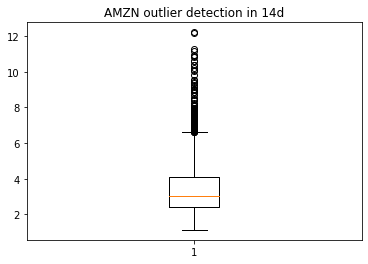

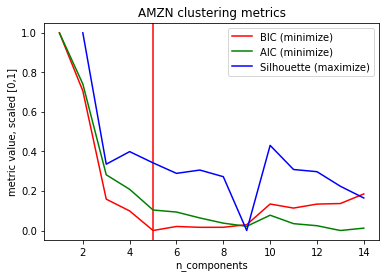

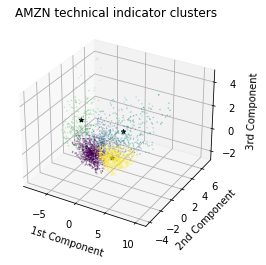

0.4414297200165187 3.9349583853996655 5.72512202810524
(2225,)
(2417, 14)
(2225, 14)


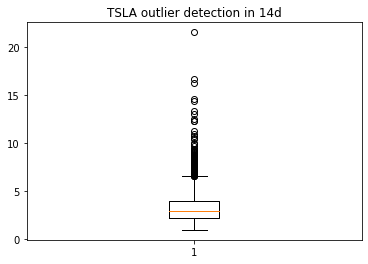

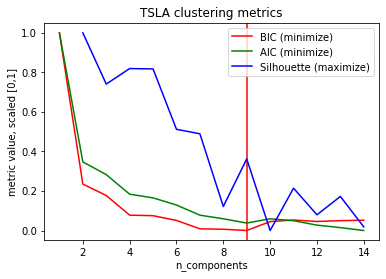

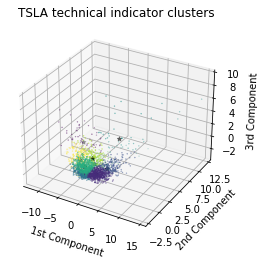

1.1422948653025928 4.883511790303631 5.565554224589269
(1574,)
(1700, 14)
(1574, 14)


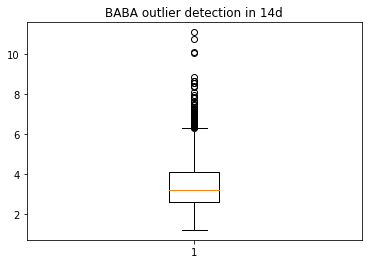

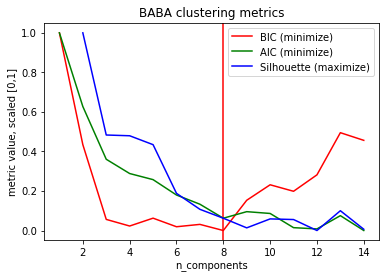

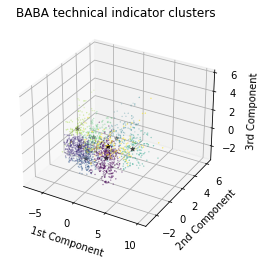

0.7146911859720548 5.712900478460219 5.54501882770966
(2263,)
(2417, 14)
(2263, 14)


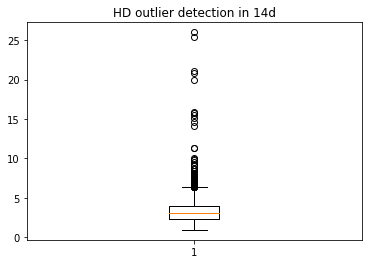

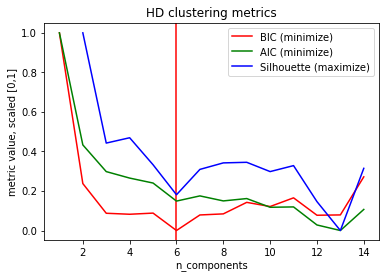

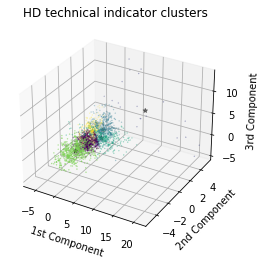

0.690090661525633 5.9048568231520235 6.009438080606256
(2293,)
(2417, 14)
(2293, 14)


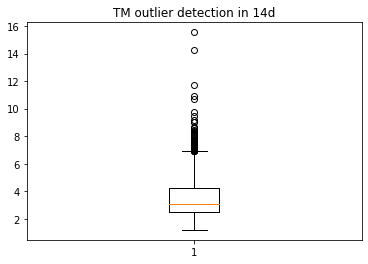

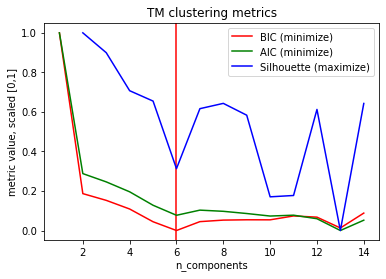

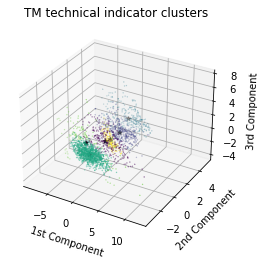

0.732424097409329 3.9015504463436823 5.6291592895884035
(2280,)
(2417, 14)
(2280, 14)


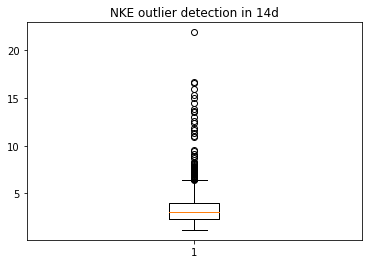

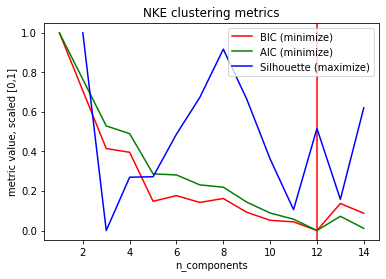

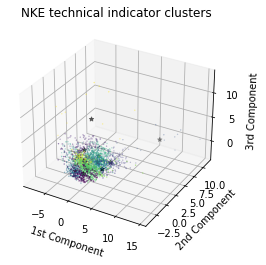

0.9197147379165012 3.3472877271886654 5.31076035855034
(2246,)
(2417, 14)
(2246, 14)


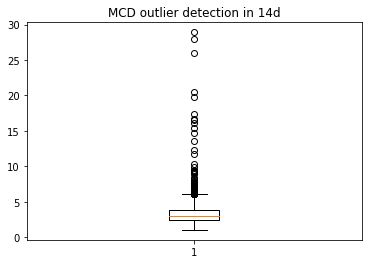

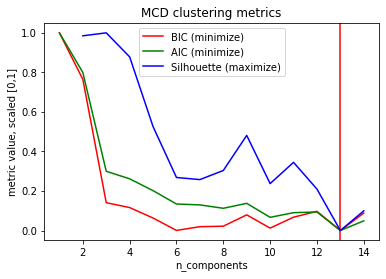

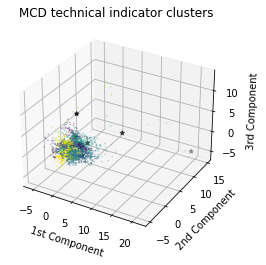

0.5891023639885078 6.158958688038352 5.610464867574631
(2265,)
(2417, 14)
(2265, 14)


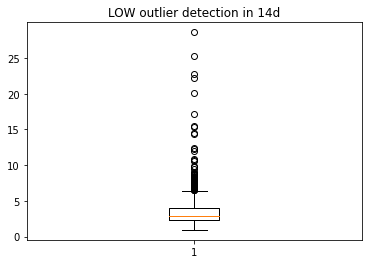

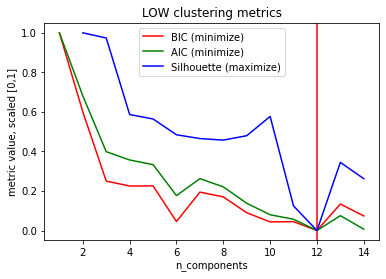

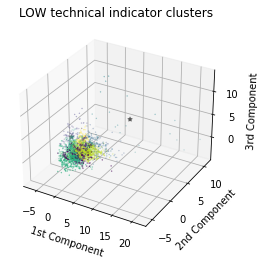

0.8348728807619001 6.2339643359283885 5.401580772466533
(2235,)
(2417, 14)
(2235, 14)


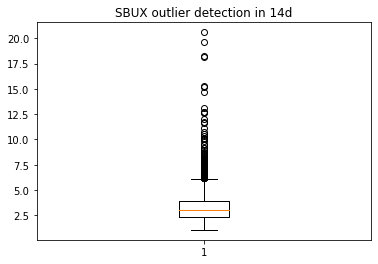

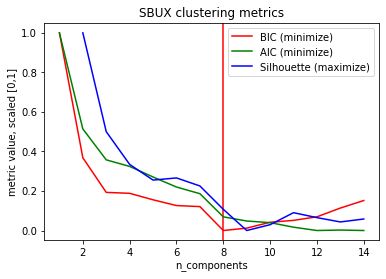

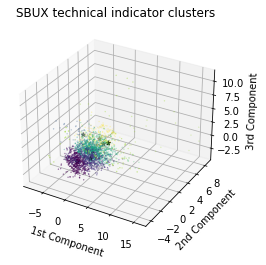

1.1476430638740691 4.725443607430016 5.533397435435424
(1655,)
(1783, 14)
(1655, 14)


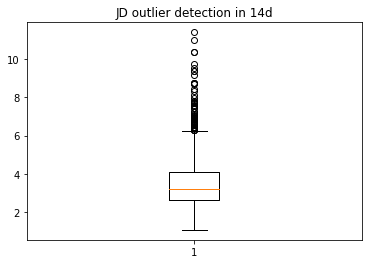

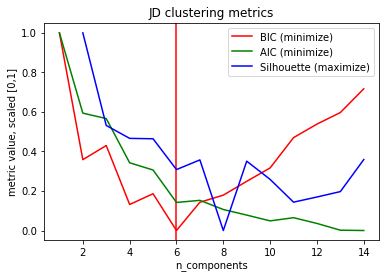

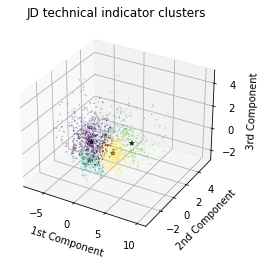

1.0991570212693542 4.07773843931947 5.5768254606510705
(674,)
(731, 14)
(674, 14)


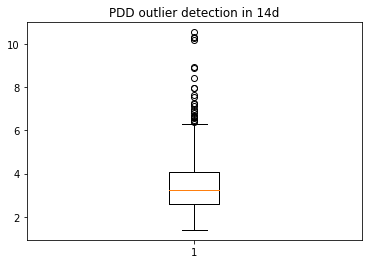

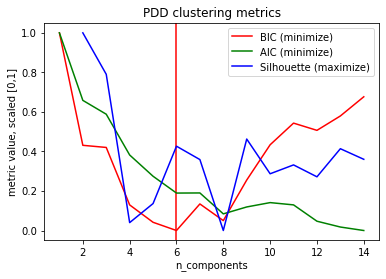

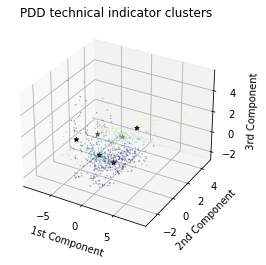

0.5549573631279539 7.1922537493037435 5.673978825727897
(2239,)
(2417, 14)
(2239, 14)


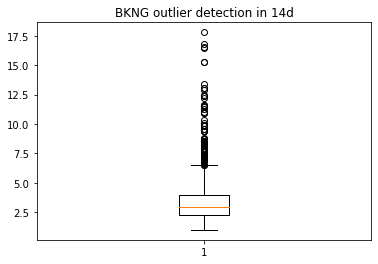

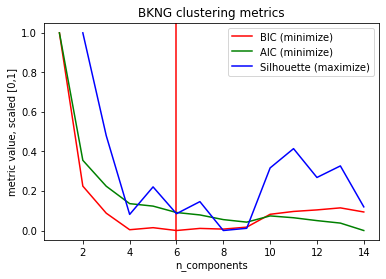

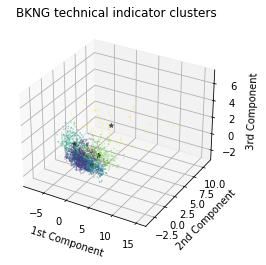

0.8424837110249528 2.8383264251046105 5.377905000531571
(2248,)
(2417, 14)
(2248, 14)


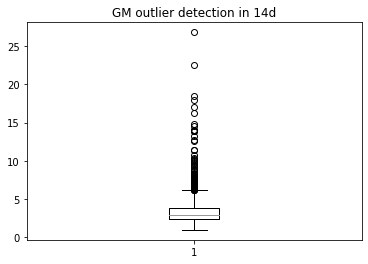

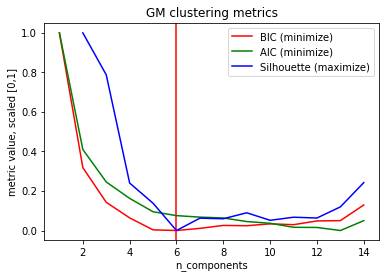

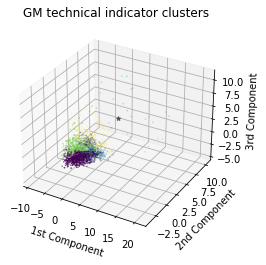

1.0152893559460825 3.144310360944341 5.613415687672304
(2240,)
(2417, 14)
(2240, 14)


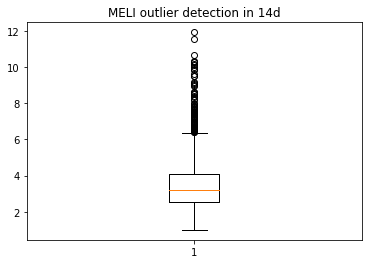

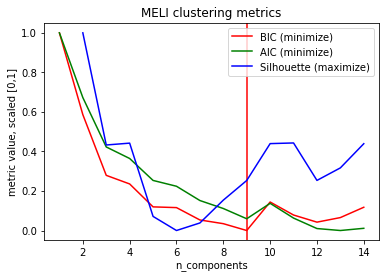

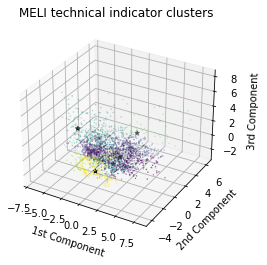

0.6161323243836776 5.223607093088927 5.572086181665272
(2289,)
(2417, 14)
(2289, 14)


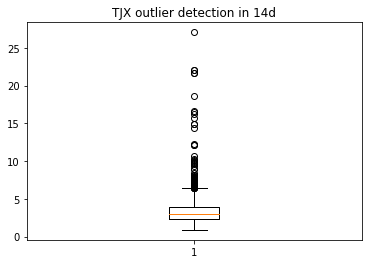

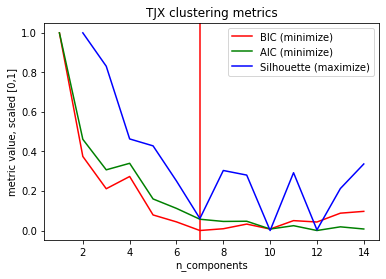

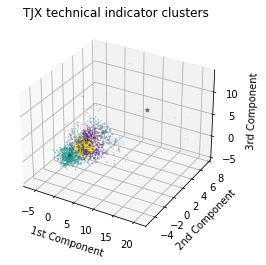

0.6277234614744005 3.862445298916193 5.679660660126187
(620,)
(698, 14)
(620, 14)


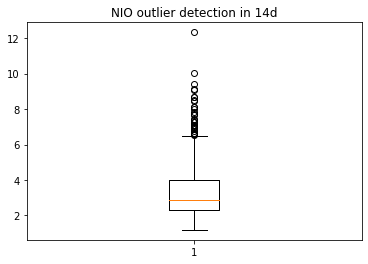

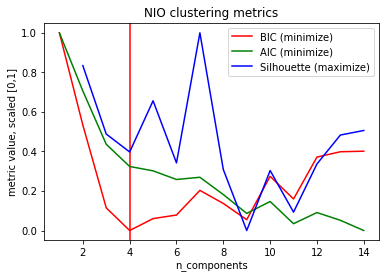

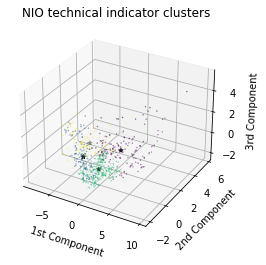

0.8071725588503522 3.158196759851619 5.282130878828589
(2200,)
(2417, 14)
(2200, 14)


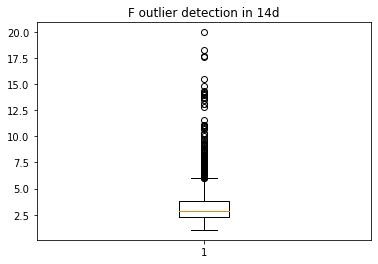

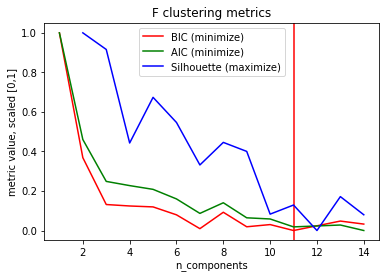

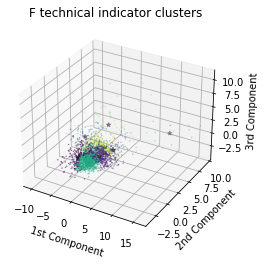

0.8058094533124556 3.6331331527507933 5.295205444645957
(2192,)
(2417, 14)
(2192, 14)


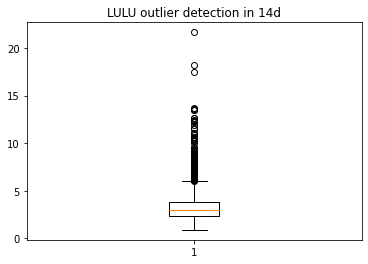

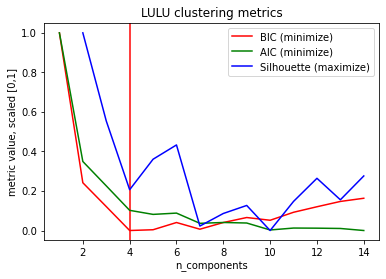

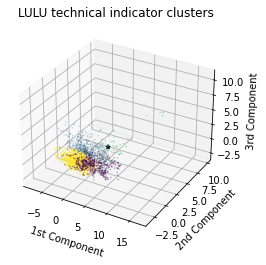

0.864226714628014 4.729138322687913 5.678212046323871
(2261,)
(2417, 14)
(2261, 14)


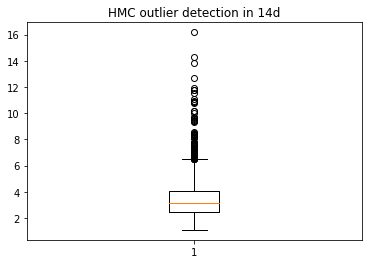

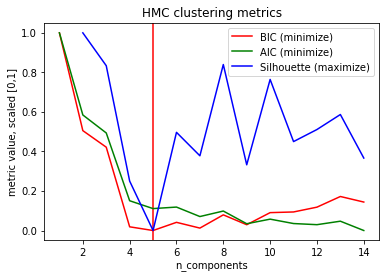

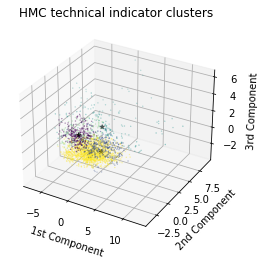

0.5262741807768014 3.0961134456445123 5.471651084538507
(2203,)
(2417, 14)
(2203, 14)


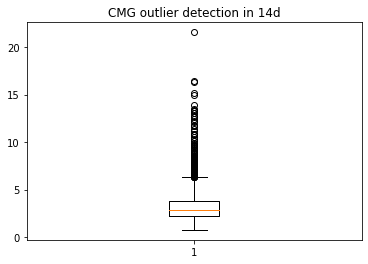

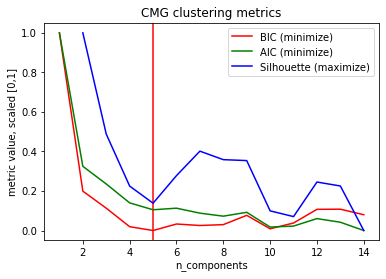

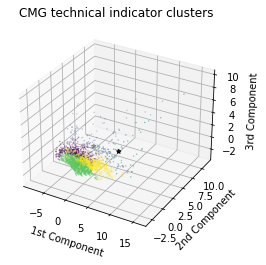

In [25]:
print("Clustering stocks using GMM")
for i in range(len(tickers)):

    # read in data from csv
    data = pd.read_csv(f'./data/{tickers[i]}.csv')

    # generate matrix with technical indicators (features) as columns
    features = data.to_numpy()[:, 6:]

    # normalize each feature
    scaler = StandardScaler()
    X = scaler.fit_transform(features)
    
    center = np.mean(X, axis=0)
    
    distToCenter = np.linalg.norm(X-center, axis=1)
    
    q75, q25 = np.percentile(distToCenter, [75 ,25])
    
    iqr = q75 - q25
    
    print(q25 - 1 * iqr, distToCenter[0], q75 + 1 * iqr)


    # nonOutlierIndices = np.argwhere(distToCenter < q75 + 1 * iqr)
    nonOutlierIndices = np.argwhere((distToCenter < q75 + 1 * iqr) & (distToCenter > q25 - 1 * iqr)).reshape(-1)
    print(nonOutlierIndices.shape)
    print(features.shape)
    features = features[nonOutlierIndices]
    print(features.shape)

    # fig = plt.figure()
    # plt.boxplot(distToCenter)
    # plt.title(f'{tickers[i]} outlier detection in {features.shape[1]}d')
    # plt.show()

    from sklearn.decomposition import PCA
    pca = PCA(n_components=3)
    X = pca.fit_transform(X)

    # newPlot = plt.figure(i)
    # newPlot.suptitle(tickers[i])
    n_components = np.arange(1, features.shape[1]+1)
    gmms = [GaussianMixture(n_components=k, covariance_type='full').fit(X) for k in n_components]

    
    bics = np.array([gmm.bic(X) for gmm in gmms])
    aics = np.array([gmm.aic(X) for gmm in gmms])
    
    minidx = np.argmin(bics)
    centroids = gmms[minidx].means_

    # calculate metrics
    silhouettes = [metrics.silhouette_score(X, gmms[k-1].predict(X)) for k in n_components[1:]]

    # descale centroids
    centroids_descaled = scaler.inverse_transform(pca.inverse_transform(centroids))

    # create df for centroids
    centroids_df = pd.DataFrame(centroids_descaled, columns=data.columns[6:])
    if not os.path.exists("centroids"):
        os.mkdir("centroids")
    centroids_df.to_csv(f'./centroids/{tickers[i]}_centroids.csv')


    # plot the results
    fig = plt.figure()
    plt.title(f"{tickers[i]} clustering metrics")
    plt.axvline(x=minidx + 1, color='r')
    plt.plot(n_components, minmax_scale(bics), label='BIC (minimize)', color='r')
    plt.plot(n_components, minmax_scale(aics), label='AIC (minimize)', color='g')
    plt.plot(n_components[1:], minmax_scale(silhouettes), label='Silhouette (maximize)', color='b')
    plt.legend(loc='best')
    plt.xlabel('n_components')
    plt.ylabel('metric value, scaled [0,1]')

    plt.show()


    fig = plt.figure()
    ax = plt.axes(projection='3d')
    ax.scatter3D(X[:, 0], X[:, 1], X[:, 2], s=0.1, c=gmms[minidx].predict(X), cmap='viridis')
    ax.scatter3D(centroids[:, 0], centroids[:, 1], centroids[:, 2], marker='*', c='black')
    ax.set_xlabel("1st Component")
    ax.set_ylabel("2nd Component")
    ax.set_zlabel("3rd Component")
    plt.title(f"{tickers[i]} technical indicator clusters")

    plt.show()

    # plt.plot(n_components[1:], silhouette_avg, label='SC')
    # plt.legend(loc='best')
    # plt.xlabel('n_components')
    # plt.ylabel('Sillhouette Score')
    # plt.show()
